In [24]:
from mlxtend.plotting import plot_decision_regions
import colorsys 
import PIL 
import glob
import numpy as np 
import random 
from matplotlib import pyplot as plt 
%matplotlib inline
import tqdm

#KNN
from sklearn.utils import shuffle 
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier


## แปลงสี

In [25]:
# colorsys

def hex_to_rgb(hex_str): #แปลงเลขฐาน 16 เป็น RGB

#     >>> hex_to_rgb('228B22')
#     (34, 139, 34)

    if hex_str.startswith('#'):
        hex_str = hex_str[1:]
    return tuple([int(hex_str[i:i + 2], 16) for i in range(0, len(hex_str), 2)])

def scale_rgb_tuple(rgb, down=True):  #ปรับขนาด tuple RGB ขึ้นหรือลงเป็น/จากค่าระหว่าง 0 ถึง 1
    if not down:
        return tuple([int(c*255) for c in rgb])
    return tuple([round(float(c)/255, 2) for c in rgb])

def hex_to_hsl(hex_str): #แปลงเลขฐาน 16 เป็น HLS
    rgbs = scale_rgb_tuple(hex_to_rgb(hex_str))
    return colorsys.rgb_to_hls(rgbs[0],rgbs[1],rgbs[2])

def clamp(x):
    return max(0,min(x,255))

def rgbToHex(r,g,b):  
    return "{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b))

## Image to Dataset Adder

In [3]:
asarray = np.asarray
def hexFromImg(path):
    image = PIL.Image.open(path);
    imageArray = asarray(image)
    hexColors=set()
    # For the Image
    for ix in range(imageArray.shape[0]):
        for iy in range(imageArray.shape[1]):
            # For the pixel
            rgb = tuple([ imageArray[ix,iy,iz] for iz in range(imageArray.shape[2])])
            hexColors.add(rgbToHex(rgb[0],rgb[1],rgb[2]))
    return hexColors

## ค่าของสีที่ใช้ในการ Train

In [26]:
canonicalBlond="faf0be"
_blondColors=set([
    canonicalBlond,
    "fcf9f5", "faf6ef", "f8f2e8", "f6efe2", "f4ebdc", "f2e8d6", 
    "f1e4cf", "efe1c9", "edddc3", "ebdabc", "e9d6b6", "e7d3b0", 
    "e5cfaa", "e3cca3", "e2c89d", "e0c597", "dec190", "dcbe8a", 
    "daba84", "d8b77d", "d6b377" , "d5b071", "d3ac6b", "d1a964", 
    "cfa55e", "cda258", "cb9e51", "c99b4b", "c79745", "c6943f",
    "c39039", "bc8b37", "b68736", "b08234", "a97d32", "a37930",
    "9d742e", "976f2c", "906b2a", "8a6629", "846127", "7d5d25",
    "775823", "715321", "6b4f1f", "644a1d", "5e451b", "58411a",
    "513c18", "4b3716", "453314", "3e2e12", "382910", "32250e"
    "2c200d", "251b0b", "1f1709", "191207", "120d05", "0c0903"
])

canonicalBlack="000000"
_blackColors=set([
    canonicalBlack,
    "f8f8f8","f4f4f4","f0f0f0","ececec","e8e8e8","e4e4e4",
    "e0e0e0","dcdcdc","d8d8d8","d4d4d4","d0d0d0","ccc000",
    "c7c7c7","c3c3c3","bfbfbf","bbb000","b7b7b7","b3b3b3",
    "afafaf","ababab","a7a7a7","a3a3a3","9f9f9f","9b9b9b",
    "969696","929292","8e8e8e","8a8a8a","868686","828282",
    "7e7e7e","7a7a7a","767676","727272","6e6e6e","6a6a6a",
    "666000","616161","5d5d5d","595959","555000","515151",
    "4d4d4d","494949","454545","414141","3d3d3d","393939",
    "353535","303030","303030","282828","242424","202020",
    "1c1c1c","181818","141414","101010","0c0c0c","080808"
])

canonicalBrown="a52a2a"
_brownColors=set([
    canonicalBrown,
    "2d170e","4d2d1a","6d4730","a97e6d","cc9f88", "23120B",
    "3D2314","5A3825","CC9966","2C1608", "905424","bb6d3e",
    "da874c","ed9352","ffb464", "654321","653700","fff9f2",
    "fff5ea","fef1e2","feeeda","feead2","fee6c9", "fee3c1",
    "fedfb9","fedbb1","ffd7a9","ffd4a1","ffd099", "ffcc90",
    "ffc988","ffc580","ffc178","ffbd70","ffba68", "ffb65f",
    "ffb257","ffaf4f","ffab47","ffa73f","ffa337", "ffa02e",
    "ff9c26","ff981e","ff9516","ff910e","ff8d06", "fc8900",
    "c36a00","b60000","b36100","ab5d00","a35800", "9b5400",
    "924f00","8a4b00","824700","7a4200","723e00", "6a3900",
    "613500","613500","512c00","492700","492700", "391f00",
    "301a00","281600","201100","180d00","100800", "653700","94450B" 
    
])

canonicalRed="FF0000"
_redColors=set([
    canonicalRed,
    "ff0505","ff0f0f","ff1414","ff1f1f",'ff2929',"ff2e2e",
    "ff3838","ff4242","ff4747","ff5252","ff5c5c""ff6161",
    "ff6b6b","ff7575","ff7a7a","f50000","f00000","e60000",
    "e00000","db0000","d10000","cc0000","c70000","bd0000",
    "b80000","b30000","a80000","a30000","9e0000","940000"
])

canonicalGreen="228B22"
_greenColors=set([
    canonicalGreen,
    "7CFC00","7FFF00","32CD32","00FF00","228B22","008000",
    "006400","ADFF2F","9ACD32","00FF7F","00FA9A","90EE90",
    "98FB98","8FBC8F","3CB371","20B2AA","2E8B57","808000",
    "556B2F","6B8E23"
])

# canonicalPurple="800080"
# _purpleColors=set([
#     canonicalPurple,
#     "E6E6FA","D8BFD8","DDA0DD","EE82EE","DA70D6","FF00FF",
#     "BA55D3"," 9370DB","8A2BE2","9400D3","9932CC","8B008B",
#     "800080","4B0082"
 
# ])

# canonicalPink="FFB6C1"
# _pinkColors=set([
#     canonicalPink,
#     "9F2B68","F2D2BD","DE3163","811331","FF7F50","F88379",
#     "DC143C","AA336A","C9A9A6","FF00FF","FF69B4","FFB6C1",
#     "FF00FF","F3CFC6","770737","FF10F0","DA70D6","F8C8DC",
#     "FAA0A0","FFC0CB","F89880","673147","A95C68","800080",
#     "E30B5C","953553","F33A6A","E0BFB8","C21E56","E0115F",
#     "FA8072","FFF5EE","D8BFD8","E37383"
# ])

# canonicalYellow="FFFF00"
# _yellowColors=set([
#     canonicalYellow,
#     "ffff00","ffff19","ffff32","ffff4c","ffff66","ffff7f",
#     "ffff99","ffffb2","ffffcc","#ffffe5"
# ])

# Here is where the original color space keys are specifieds
colorSpaces={
    "black":_blackColors,
    "brown":_brownColors,
    "blond":_blondColors,
    "red":_redColors,
    "green":_greenColors,
    #"purple":_purpleColors,
    #"pink":_pinkColors,
    #"yellow":_yellowColors
}
print(f"แบ่งออกเป็น {colorSpaces.keys()}")

แบ่งออกเป็น dict_keys(['black', 'brown', 'blond', 'red', 'green'])


In [27]:
for colorKey in colorSpaces:
    for filename in glob.glob("./Train/"+colorKey+"/*.*"):
        print(f"Consider {filename} as {colorKey} ")
        hexCodes = hexFromImg(filename)
        colorSpaces[colorKey].update(hexCodes)
print("Done")

Consider ./Train/black\สีดำ.png as black 
Consider ./Train/black\สีดำ1.png as black 
Consider ./Train/black\สีดำ10.PNG as black 
Consider ./Train/black\สีดำ11.PNG as black 
Consider ./Train/black\สีดำ2.PNG as black 
Consider ./Train/black\สีดำ3.PNG as black 
Consider ./Train/black\สีดำ4.PNG as black 
Consider ./Train/black\สีดำ5.PNG as black 
Consider ./Train/black\สีดำ6.jpg as black 
Consider ./Train/black\สีดำ7.jpg as black 
Consider ./Train/black\สีดำ8.jpg as black 
Consider ./Train/black\สีดำ9.PNG as black 
Consider ./Train/brown\br.jpg as brown 
Consider ./Train/brown\brown2.PNG as brown 
Consider ./Train/brown\brown3.png as brown 
Consider ./Train/brown\brown4.jpg as brown 
Consider ./Train/brown\brown5.jpg as brown 
Consider ./Train/brown\brown6.6.jpg as brown 
Consider ./Train/brown\brown7.jpg as brown 
Consider ./Train/brown\brown8.jpg as brown 
Consider ./Train/blond\blonde.jpg as blond 
Consider ./Train/blond\blonde1.jpg as blond 
Consider ./Train/blond\blonde2.jpg as blond 

## Preprocessing 


In [28]:
# ประมวลผลล่วงหน้า แปลงเป็น HLS color spaces
print("Preprocessing HEX space to HLS Space")
hlsColorSpaces={colorKey:[hex_to_hsl(color) for color in colorSpaces[colorKey]] for colorKey in colorSpaces}

#Shuffle each of the spaces:   สุ่มแต่ละช่องว่าง:
print("Randomizing the space sequences for HLS space")  #กสุ่มลำดับพื้นที่สำหรับ HLS space
for colorKey in hlsColorSpaces:
    random.shuffle(hlsColorSpaces[colorKey])
    
# Sampled Space  พื้นที่สุ่มตัวอย่าง
minSize=-1
for colorKey in hlsColorSpaces:
    print(f"Space:{colorKey} Size:{len(hlsColorSpaces[colorKey])}")
    if len(hlsColorSpaces[colorKey])<minSize or minSize==-1:
        minSize=len(hlsColorSpaces[colorKey])
N_SAMPLES=int(minSize*0.9)
print(f"Sampling Size {N_SAMPLES} (10% hit on the smallest size)")
sampledSpace = {colorKey:np.array(hlsColorSpaces[colorKey][0:min(N_SAMPLES,len(hlsColorSpaces[colorKey]))]) for colorKey in hlsColorSpaces}


Preprocessing HEX space to HLS Space
Randomizing the space sequences for HLS space
Space:black Size:27673
Space:brown Size:214099
Space:blond Size:57195
Space:red Size:128730
Space:green Size:150499
Sampling Size 24905 (10% hit on the smallest size)


## สร้างพล็อตของสี

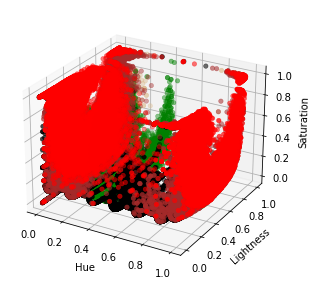

In [29]:
# เข้าถึงฟังก์ชัน Slicing สำหรับแต่ละพิกัด
X = lambda a : a[:,0:1]
Y = lambda a : a[:,1:2]
Z = lambda a : a[:,2:3]

# Plot Setup
fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot(111, projection='3d')# สร้างแกน 3 มิติ
fig.set_size_inches(5, 5)

ax.set_xlabel('Hue')
ax.set_ylabel('Lightness')
ax.set_zlabel('Saturation')

ax.view_init(25,300) #มุม


colorNameToRGB={
    "black":"black",
    "brown":"brown",
    "blond":"#dcbd92",
    "gray":"gray",
    "red":"red",
    "green":"green",
#     "pink":"ff4767",
#     "purple":"800080",
#     "yellow":"yellow"
}

for colorKey in sampledSpace:
    ax.scatter(X(sampledSpace[colorKey]),Y(sampledSpace[colorKey]),Z(sampledSpace[colorKey]),color=colorNameToRGB[colorKey],linewidth=0.5)
plt.show()

## Fit the KNN Model

In [30]:
#Prepare the Data:  colorName: int associated with that number  #เตรียมข้อมูล: colorName: int ที่สัมพันธ์กับตัวเลขนั้น
print("Number Classification") #Generating Classification Numbers
colorKeyToInt={part[0]:part[1] for part in zip(hlsColorSpaces.keys(),range(len(hlsColorSpaces.keys())))}
intToColorKey = {colorKeyToInt[colorKey]:colorKey for colorKey in colorKeyToInt}
for colorKey in colorKeyToInt:
    print(f"Color: {colorKey} Has ID: {colorKeyToInt[colorKey]}")

#เชื่อมข้อมูลให้เป็นอาร์เรย์ยาว BIIIIG เดียว
x_data = None
y_data = None
first=True
for colorKey in colorKeyToInt:
    if first:
        x_data = sampledSpace[colorKey]
        y_data = colorKeyToInt[colorKey]*np.ones(len(sampledSpace[colorKey]),dtype=int)
        first=False
    else:
        x_data = np.concatenate((x_data,sampledSpace[colorKey]), axis=0)
        y_data = np.concatenate((y_data,colorKeyToInt[colorKey]*np.ones(len(sampledSpace[colorKey]),dtype=int)),axis=0)

x_data, y_data = shuffle(x_data, y_data, random_state=random.randint(0,10))

Number Classification
Color: black Has ID: 0
Color: brown Has ID: 1
Color: blond Has ID: 2
Color: red Has ID: 3
Color: green Has ID: 4


In [40]:
# Performing 3 Fold Validation
k = KFold(n_splits=5,shuffle=True)

# Generating Range
nearestCounts = list(range(5,45,5))

# Create a list of errors (per each fold)
errors=[]

#For each fold
currentFold=0
for train_index, test_index in k.split(x_data):
    #Append a place to store the errors for the fold
    errors.append([])
    
    
    # for each KNN (n nearest)
    for n in nearestCounts:
        # สร้างตัวแยกประเภท KNN
        classifier = KNeighborsClassifier(n_neighbors=n,algorithm='auto') ##Ball tree , brute, auto , kd_tree
        
        
        # ดีงข้อมูล Train 
        train_data_x = []
        train_data_y = []
        for index in train_index:
            train_data_x.append(x_data[index])
            train_data_y.append(y_data[index])
            
        #FIT the classifer
        print(f"Fitting Classifier Fold:{currentFold}  N-Nearest:{n}")
        classifier.fit(np.array(train_data_x),np.array(train_data_y))

        #Extract Test Data แยกข้อมูลการทดสอบ
        test_data_x = []
        test_data_y = []
        for index in test_index:
            test_data_x.append(x_data[index])
            test_data_y.append(y_data[index])
        
        #Predict
        print("  Predict")
        prediction = classifier.predict(test_data_x)
        print("  Error calculations")
        # คำนวณข้อผิดพลาดเฉลี่ยสำหรับ fold
        errors[currentFold].append(np.mean(prediction != test_data_y))
        
    #Increment the fold
    currentFold+=1
    
print("Done")

Fitting Classifier Fold:0  N-Nearest:5
  Predict
  Error calculations
Fitting Classifier Fold:0  N-Nearest:10
  Predict
  Error calculations
Fitting Classifier Fold:0  N-Nearest:15
  Predict
  Error calculations
Fitting Classifier Fold:0  N-Nearest:20
  Predict
  Error calculations
Fitting Classifier Fold:0  N-Nearest:25
  Predict
  Error calculations
Fitting Classifier Fold:0  N-Nearest:30
  Predict
  Error calculations
Fitting Classifier Fold:0  N-Nearest:35
  Predict
  Error calculations
Fitting Classifier Fold:0  N-Nearest:40
  Predict
  Error calculations
Fitting Classifier Fold:1  N-Nearest:5
  Predict
  Error calculations
Fitting Classifier Fold:1  N-Nearest:10
  Predict
  Error calculations
Fitting Classifier Fold:1  N-Nearest:15
  Predict
  Error calculations
Fitting Classifier Fold:1  N-Nearest:20
  Predict
  Error calculations
Fitting Classifier Fold:1  N-Nearest:25
  Predict
  Error calculations
Fitting Classifier Fold:1  N-Nearest:30
  Predict
  Error calculations
Fitting 

## Plot Mean Error vs K value 

Text(0, 0.5, 'Mean Error')

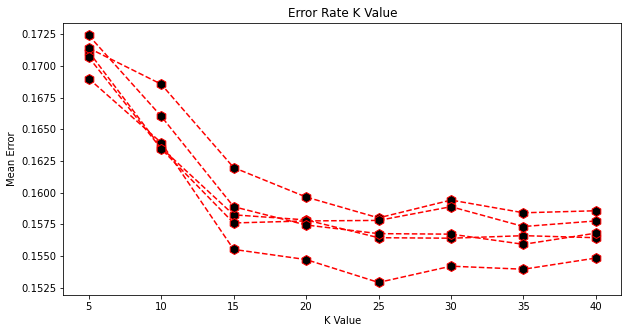

In [41]:
plt.figure(figsize=(10, 5))
for error in errors:
    plt.plot(nearestCounts, error, color='red', linestyle='dashed', marker='h', markerfacecolor='black', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

## Create the Main Classifier 

In [42]:
classifier = KNeighborsClassifier(n_neighbors=100,algorithm='auto')
classifier.fit(x_data,y_data)

KNeighborsClassifier(n_neighbors=100)

## Create a function  จำแนกสีผมตามโมเดล

In [43]:
def classify_pic(pic,classifier):
    # สร้างอาร์เรย์ของ pixel colors
    hlsColors = []
    
    # Count of each class: will be converted to fraction
    classCoverage={colorKey:0 for colorKey in sampledSpace }
    
    #  Image
    for ix in tqdm.tqdm(range(pic.shape[0])):
        for iy in range(pic.shape[1]):
            # For the pixel
            rgbs= scale_rgb_tuple(tuple([ pic[ix,iy,iz] for iz in range(pic.shape[2])]))
            hsltuple=colorsys.rgb_to_hls(rgbs[0],rgbs[1],rgbs[2])
            #Append that pixel to the list ผนวกพิกเซลนั้นเข้ากับรายการ
            hlsColors.append(hsltuple)
    
    # Predict the color based on the classifier  ทำนายสีตามclassifier
    predictions = classifier.predict(np.array(hlsColors))
    
    # Sum the counts for each class
    for i in range(0,predictions.size):
        ck = intToColorKey[predictions[i]]
        classCoverage[ck]+=1
    # scale them
    for colorKey in classCoverage:
        classCoverage[colorKey] = classCoverage[colorKey]/predictions.size
    
    # Calculate the ratio of Blonds: (0 for blond 1 for brown)
    #return np.sum(predictions)/len(predictions)
    return classCoverage


In [44]:
def generateColorImage(rgbArray,dim=(3,3)):
#     '''
#     Creates a  AxB sized image where dim=(A,B)
#     of the specified rgb color (R,G,B)
#     where R,G,B are integers [0,255]
#     '''
    pic = np.ones((dim[0],dim[1],3),dtype=np.int16)
    for ix in range(pic.shape[0]):
        for iy in range(pic.shape[1]):
            for iz in range(rgbArray.shape[0]):
                print(f"{ix},{iy},{iz}")
                pic[ix,iy,iz] = rgbArray[iz]
    return pic

## Testing

In [45]:

# Raw pixel Based
d = lambda x: np.delete(x,1,axis=1)
brown=np.array([hex_to_hsl(canonicalBrown)])
blond=np.array([hex_to_hsl(canonicalBlond)])
red=np.array([hex_to_hsl(canonicalRed)])
green=np.array([hex_to_hsl(canonicalGreen)])
print(f" Brown {brown} Predicted : {classifier.predict(brown)}")
print(f" Blond {blond} Predicted : {classifier.predict(blond)}")
print(f" Red {blond} Predicted : {classifier.predict(red)}")
print(f" Green {green} Predicted : {classifier.predict(green)}")

# Iterated Pixel test
# Raw pixel Based
d = lambda x: np.delete(x,1,axis=1)
brown=np.array([hex_to_hsl(list(_brownColors)[random.randint(0,len(_brownColors)-1)])])
blond=np.array([hex_to_hsl(list(_blondColors)[random.randint(0,len(_blondColors)-1)])])
red=np.array([hex_to_hsl(list(_redColors)[random.randint(0,len(_redColors)-1)])])
green=np.array([hex_to_hsl(list(_greenColors)[random.randint(0,len(_greenColors)-1)])])
print(f" Brown {brown} Predicted : {classifier.predict(brown)}")
print(f" Blond {blond} Predicted : {classifier.predict(blond)}")
print(f" Red {blond} Predicted : {classifier.predict(red)}")
print(f" Green {green} Predicted : {classifier.predict(green)}")

 Brown [[0.         0.405      0.60493827]] Predicted : [3]
 Blond [[0.13768116 0.865      0.85185185]] Predicted : [2]
 Red [[0.13768116 0.865      0.85185185]] Predicted : [3]
 Green [[0.33333333 0.34       0.61764706]] Predicted : [4]
 Brown [[0.05782313 0.405      0.60493827]] Predicted : [1]
 Blond [[0.08045977 0.445      0.3258427 ]] Predicted : [2]
 Red [[0.08045977 0.445      0.3258427 ]] Predicted : [3]
 Green [[0.28294574 0.435      0.49425287]] Predicted : [4]


In [49]:
test_image="./Test/testbl.jpg"


## Load the Image

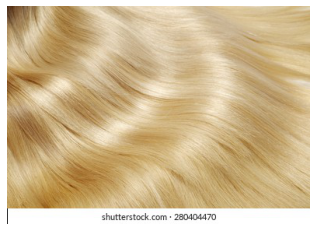

In [50]:
image = PIL.Image.open(test_image);
imageArray = asarray(image)
plt.figure()
plt.axis('off') #ปิดตัวเลขกรอบ
plt.imshow(imageArray)
plt.show()

## Classify the Image 

In [51]:
print("Hiar Color Image Classification Decomposition ")
cDecomp = classify_pic(imageArray,classifier)
for colorKey in cDecomp:
    print(f"Color: {colorKey} {round(cDecomp[colorKey]*1000)/10}%")

Hiar Color Image Classification Decomposition 


100%|██████████| 280/280 [00:00<00:00, 405.12it/s]


Color: black 4.1%
Color: brown 4.6%
Color: blond 91.0%
Color: red 0.2%
Color: green 0.1%
